In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
import os 
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

In [87]:
from config import BASELINE_META_MODEL_DIR, BASELINE_META_MODEL_DIR, SARIMAX_CATEGORY_CLUSTER_DIR
from meta_data_utils import sanitize_filename, get_meta_data, get_cat_to_articles
from data_utils import load_data, get_date_columns, check_stationarity, get_page_to_article_domain_mapping, filter_articles, get_page_info_df
from plot_utils import plot_stacked_time_series

In [46]:
raw_data = load_data(transpose=False, remove_inactive_articles=True)
date_columns = get_date_columns(raw_data)

In [ ]:
page_info_df = get_page_info_df()

In [54]:
merged_df = pd.merge(page_info_df[['page', 'article']], raw_data, on='page', how='inner')
merged_df.drop('page', axis=1, inplace=True)
df = merged_df.copy()
del merged_df

df.set_index('article', inplace=True)
df = df.T
df.index = pd.to_datetime(df.index)
df.head()

article,2NE1,2PM,3C,4minute,5566,A'N'D,AKB48,ASCII,Ahq_e-Sports_Club,All_your_base_are_belong_to_us,...,Transgénero,Edad_Contemporánea,Salvador_Dalí,Soraya_Jiménez,Día_Internacional_del_Beso,Chichén_Itzá,Fecundación,Gran_Hermano_VIP_(España),Modelo_atómico_de_Thomson,Copa_América_2019
2015-07-01,18.0,11.0,1.0,35.0,12.0,118.0,5.0,6.0,2.0,2.0,...,4.0,21.0,23.0,3.0,1.0,8.0,29.0,4.0,0.0,3.0
2015-07-02,11.0,14.0,0.0,13.0,7.0,26.0,23.0,3.0,1.0,5.0,...,3.0,32.0,40.0,7.0,3.0,13.0,16.0,25.0,2.0,10.0
2015-07-03,5.0,15.0,1.0,10.0,4.0,30.0,14.0,5.0,4.0,5.0,...,4.0,38.0,55.0,6.0,8.0,19.0,6.0,7.0,6.0,41.0
2015-07-04,13.0,18.0,1.0,94.0,5.0,24.0,12.0,12.0,4.0,1.0,...,17.0,21.0,32.0,3.0,3.0,14.0,11.0,11.0,6.0,17.0
2015-07-05,14.0,11.0,0.0,4.0,20.0,29.0,9.0,6.0,2.0,3.0,...,28.0,28.0,42.0,3.0,6.0,6.0,33.0,6.0,7.0,16.0


### Categories: Wikipedia API

In [55]:
cat_to_articles = get_cat_to_articles()
cat_to_articles = filter_articles(cat_to_articles, df)

### Group the categories into a smaller number of overarching themes or topics [Topic Modeling]

In [57]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.parsing.preprocessing import remove_stopwords

from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

category_names = list(cat_to_articles.keys())

# Preprocessing 
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = str(text)
    text = text.replace("Category:", "")
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Preprocess category names
preprocessed_category_names = [preprocess_text(name) for name in category_names]

# Vectorize the preprocessed category names using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(preprocessed_category_names)

# Apply LDA to identify topics
num_topics = 20  
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

# Get the topic distribution for each category
topic_distribution = lda.transform(tfidf_matrix)

# Assign each category to the most probable topic
category_to_topic = {}
for i, category in enumerate(category_names):
    topic = np.argmax(topic_distribution[i])
    category_to_topic[category] = topic

# Group categories by their assigned topic
from collections import defaultdict
topic_to_categories = defaultdict(list)
for category, topic in category_to_topic.items():
    topic_to_categories[topic].append(category)

# Function to get the top words for each topic
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return top_words

# Get the feature names (words) from the TF-IDF vectorizer
tf_feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic
top_words = get_top_words(lda, tf_feature_names, 10)

# Print the top words for each topic
for topic, words in top_words.items():
    print(f"Topic {topic}:")
    print(words)
    print("\n")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ajaykarthicksenthilkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0:
['deaths', 'books', 'set', 'lgbt', 'user', 'children', '1992', 'animal', 'characters', '2006']


Topic 1:
['statements', 'articles', 'unsourced', 'dates', 'use', 'potentially', 'dated', 'containing', 'expanded', 'russian']


Topic 2:
['stubs', 'births', 'geography', 'sport', 'musical', 'groups', 'biography', 'competitions', 'american', 'poets']


Topic 3:
['united', 'states', 'summer', 'olympics', 'kingdom', 'described', 'dmy', '2016', 'murders', 'establishments']


Topic 4:
['actresses', 'actors', 'fictional', 'argentine', 'world', 'sportspeople', 'male', 'video', 'cup', 'expatriate']


Topic 5:
['albums', '20thcentury', '21stcentury', 'singers', 'women', 'spanish', 'italian', '19thcentury', 'male', '18thcentury']


Topic 6:
['australia', 'south', 'africa', 'african', 'america', 'london', 'establishments', 'radio', 'jews', '1991']


Topic 7:
['films', '2010s', 'comedy', 'american', 'drama', '2000s', 'action', '1990s', '1970s', 'thriller']


Topic 8:
['articles', 'lacking', 'r

In [65]:
def create_article_topic_mappings(cat_to_articles, category_to_topic):
    article_to_topics = {}
    topic_to_articles = defaultdict(list)

    # Create article_to_topics mapping
    for category, articles in cat_to_articles.items():
        if category in category_to_topic:
            topic = category_to_topic[category]
            for article in articles:
                if article not in article_to_topics:
                    article_to_topics[article] = topic

    # Create topic_to_articles mapping
    for article, topic in article_to_topics.items():
        topic_to_articles[topic].append(article)

    return article_to_topics, topic_to_articles

article_to_topics, topic_to_articles = create_article_topic_mappings(cat_to_articles, category_to_topic)

In [70]:
def compute_within_cluster_variance(data_df, cluster_to_articles):
    scores = defaultdict(dict)
    scaler = StandardScaler()

    # Compute within-cluster variance for each cluster
    for cluster_id, articles in tqdm(cluster_to_articles.items(), total=len(cluster_to_articles.items())):
        filtered_articles = [article for article in articles if article in data_df.columns]
        if len(filtered_articles) < 10:
            continue  # Need at least 10 articles to compute any meaningful measure

        # Extract and standardize data
        category_data = scaler.fit_transform(data_df[filtered_articles].fillna(0).T)

        # Use PCA to reduce dimensionality for large data sets
        pca = PCA(n_components=min(category_data.shape) - 1 if category_data.shape[0] > 2 else 2)
        reduced_data = pca.fit_transform(category_data)

        # Calculate variance within the cluster
        variance = np.var(reduced_data, axis=0).mean()  # Average variance across all components
        scores[cluster_id] = [variance, len(filtered_articles)]

    return pd.DataFrame(scores, index=['Variance', 'Num_Articles']).T

within_cluster_variance = compute_within_cluster_variance(df, topic_to_articles)

within_cluster_variance


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.35s/it]


,Variance,Num_Articles
13,5.904412,35.0
11,1.001247,1893.0
16,1.001246,3564.0
1,1.001247,2282.0
8,1.001246,2585.0
6,1.001247,790.0
12,1.001247,2000.0
0,2.712838,69.0
10,1.515094,162.0
18,9.125000,34.0


In [71]:
def create_aggregated_df_with_proportions(data_df, topic_to_articles):
    # Initialize an empty DataFrame with the same index as data_df
    aggregated_df = pd.DataFrame(index=data_df.index)
    
    # Dictionary to store the proportion of each article in its topic aggregation
    topic_proportions = {}

    # Iterate over each topic and its articles
    for topic_id, articles in tqdm(topic_to_articles.items(), total=len(topic_to_articles.items())):
        # Filter the articles that are present in the DataFrame
        valid_articles = [article for article in articles if article in data_df.columns]
        
        if not valid_articles:
            continue
        
        # Sum the view counts of the valid articles for each day
        aggregated_df[topic_id] = data_df[valid_articles].sum(axis=1)
        
        # Calculate the proportion of each article in the aggregation
        total_views = data_df[valid_articles].sum().sum()
        topic_proportions[topic_id] = {article: data_df[article].sum() / total_views for article in valid_articles}
    
    return aggregated_df, topic_proportions


aggregated_df, topic_proportions = create_aggregated_df_with_proportions(df, topic_to_articles)

aggregated_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:15<00:00, 12.78s/it]


,13,11,16,1,8,6,12,0,10,18,3,9,17,5,2,4,15,14,19,7
2015-07-01,136567.0,13386441.0,10780501.0,6971074.0,4161169.0,1256760.0,4607504.0,345904.0,416441.0,53644.0,277847.0,272219.0,100413.0,912210.0,138479.0,1843350.0,553403.0,261504.0,343364.0,542536.0
2015-07-02,126970.0,12909223.0,10223455.0,7031695.0,4415660.0,1233304.0,4221495.0,331257.0,637818.0,71371.0,278058.0,247341.0,97802.0,915800.0,131870.0,1866752.0,547246.0,186475.0,333747.0,564885.0
2015-07-03,120736.0,12404237.0,10000205.0,6837591.0,4175905.0,1170511.0,4047104.0,377479.0,437970.0,63225.0,256645.0,247116.0,89339.0,887073.0,136386.0,1858111.0,503813.0,167079.0,321825.0,560374.0
2015-07-04,144543.0,12604475.0,10951794.0,7731624.0,4270719.0,1168010.0,4609139.0,404367.0,396819.0,57638.0,222666.0,298278.0,92592.0,999256.0,174374.0,1937169.0,489651.0,321411.0,325452.0,560053.0
2015-07-05,174961.0,13857760.0,11438456.0,7560775.0,4730323.0,1170051.0,4982005.0,399427.0,442532.0,58628.0,232185.0,301170.0,102461.0,1042032.0,170396.0,2279548.0,563610.0,318170.0,354653.0,628651.0


In [ ]:
article_to_page = page_info_df.set_index('article')['page'].to_dict()

In [81]:
def aggregate_meta_data_for_topic(topic_to_articles, article_to_page):
    topic_exog_features = {}

    for topic, articles in tqdm(topic_to_articles.items(), total=len(topic_to_articles.items())):
        meta_dfs = []

        for article in articles:
            if article in article_to_page:
                page_name = article_to_page[article]
                meta_df = get_meta_data(page_name)
                if meta_df is None:
                    continue
                meta_dfs.append(meta_df)

        # Aggregate meta data for all articles within a topic
        if meta_dfs:
            combined_meta_df = pd.concat(meta_dfs)
            aggregated_meta_df = combined_meta_df.groupby('date').sum()
            topic_exog_features[topic] = aggregated_meta_df

    return topic_exog_features

topic_exog_features = aggregate_meta_data_for_topic(topic_to_articles, article_to_page)

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 13/20 [01:01<00:08,  1.23s/it]/Users/ajaykarthicksenthilkumar/dev/personal/wiki-forcast/ajay/meta_data_utils.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  # Assign initial_total_bytes_added to initial zeros in 'end_of_day_size'
/Users/ajaykarthicksenthilkumar/dev/personal/wiki-forcast/ajay/meta_data_utils.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  #

In [90]:
os.makedirs(SARIMAX_CATEGORY_CLUSTER_DIR, exist_ok=True)

### SARIMAX Model Building

In [105]:
def fit_sarima(series, p, d, q, P, D, Q, s, exog=None):
    model = SARIMAX(series, exog=exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            fitted_model = model.fit(disp=False)
    except Exception as e:
        print(f"Fitting SARIMA({p},{d},{q}) x ({P},{D},{Q},{s}) failed with default start parameters: {e}")
        # Retry with initial parameters set to zero
        try:
            fitted_model = model.fit(start_params=[0] * (p + q + P + Q))
        except Exception as e:
            print(f"Retry fitting SARIMA({p},{d},{q}) x ({P},{D},{Q},{s}) failed: {e}")
            return None
    return fitted_model

def find_best_sarima_model(time_series, p_values, d_values, q_values, P_values, D_values, Q_values, s, exog=None):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = fit_sarima(time_series, p, d, q, P, D, Q, s, exog)
                                if model is not None and model.aic < best_aic:
                                    best_aic = model.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, s)
                                    best_model = model
                            except Exception as e:
                                print(f"Failed to fit SARIMA({p},{d},{q}) x ({P},{D},{Q},{s}): {str(e)}")
    
    return {"order": best_order, "seasonal_order": best_seasonal_order, "model": best_model, "aic": best_aic}

def get_time_series_and_exog(data, page_name):
    time_series = data[page_name]
    time_series = time_series.asfreq('D')
    
    meta_df = topic_exog_features[page_name]
    # Ensure the index is set to 'date'
    if meta_df.index.name != 'date':
        meta_df.set_index('date', inplace=True)

    # Ensure that the exog features are aligned with the time series data
    exog = meta_df.reindex(time_series.index).asfreq('D').fillna(0)
    
    
    # # Day of the week
    # day_of_week = pd.to_datetime(time_series.index).dayofweek
    # exog_dow = pd.get_dummies(day_of_week, prefix='dow').astype(int)
    # exog_dow.index = time_series.index
    
    # # Month of the year
    # month_of_year = pd.to_datetime(time_series.index).month
    # exog_month = pd.get_dummies(month_of_year, prefix='month').astype(int)
    # exog_month.index = time_series.index
    
    # # Is weekend
    # is_weekend = (day_of_week >= 5).astype(int)
    # exog_weekend = pd.DataFrame(is_weekend, index=time_series.index, columns=['is_weekend'])
    
    # # Is holiday
    # holidays = calendar().holidays(start=time_series.index.min(), end=time_series.index.max())
    # is_holiday = time_series.index.isin(holidays).astype(int)
    # exog_holiday = pd.DataFrame(is_holiday, index=time_series.index, columns=['is_holiday'])
    
    # # Combine all exogenous features
    # exog = pd.concat([exog_dow, exog_month, exog_weekend, exog_holiday], axis=1)
    
    return time_series, exog

def train_test_split(series, exog, test_size):
    train = series[:-test_size]
    test = series[-test_size:]
    train_exog = exog[:-test_size]
    test_exog = exog[-test_size:]
    return train, test, train_exog, test_exog

def process_page(page_name, data, date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, S, test_size):
    print(f"Processing SARIMA models for page: {page_name}")
        
    # Get the time series data for the page
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    # Skip the current iteration if no data was found
    if time_series is None:
        return

    # Determine if the series is stationary
    is_stationary = check_stationarity(time_series)

    # Adjust d_values based on stationarity
    adjusted_d_values = [0] if is_stationary else d_values

    # Split the data into training and testing sets
    train_series, test_series, train_exog, test_exog =  train_test_split(time_series, exog, test_size)

    # Find the best ARIMA model for the time series
    best_model_info = find_best_sarima_model(train_series, p_values, adjusted_d_values, q_values, P_values, D_values, Q_values, S, exog=train_exog)
    
    print(f"Best SARIMA model for {page_name}: Order={best_model_info['order']} AIC={best_model_info['aic']:.2f}")

    return best_model_info


def process_and_save_models(data, date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, S, test_size):
    # Iterate over all unique pages in the DataFrame
    for page_name in data.columns:
        best_model_info = process_page(page_name, data, date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, S, test_size)
        if best_model_info is not None:
            # Save each model's information into a separate pickle file
            with open(os.path.join(SARIMAX_CATEGORY_CLUSTER_DIR, f'best_agg_model_{page_name}.pkl'), 'wb') as f:
                pickle.dump(best_model_info, f)

p_values = [0]
d_values = [1]
q_values = [0]
P_values = [1]
D_values = [1]
Q_values = [0]
s = 60

test_size = 30
process_and_save_models(aggregated_df, date_columns, p_values, d_values, q_values, P_values, D_values, Q_values, s, test_size)

Processing SARIMA models for page: 13
Best SARIMA model for 13: Order=(0, 0, 0) AIC=17819.63
Processing SARIMA models for page: 11
Best SARIMA model for 11: Order=(0, 1, 0) AIC=23293.79
Processing SARIMA models for page: 16
Best SARIMA model for 16: Order=(0, 1, 0) AIC=22589.64
Processing SARIMA models for page: 1
Best SARIMA model for 1: Order=(0, 1, 0) AIC=22165.19
Processing SARIMA models for page: 8
Best SARIMA model for 8: Order=(0, 1, 0) AIC=21858.12
Processing SARIMA models for page: 6
Best SARIMA model for 6: Order=(0, 0, 0) AIC=21017.60
Processing SARIMA models for page: 12
Best SARIMA model for 12: Order=(0, 1, 0) AIC=21196.82
Processing SARIMA models for page: 0
Best SARIMA model for 0: Order=(0, 0, 0) AIC=20914.05
Processing SARIMA models for page: 10
Best SARIMA model for 10: Order=(0, 0, 0) AIC=19734.15
Processing SARIMA models for page: 18
Best SARIMA model for 18: Order=(0, 0, 0) AIC=18167.27
Processing SARIMA models for page: 3
Best SARIMA model for 3: Order=(0, 0, 0) 

sMAPE: 13.68%


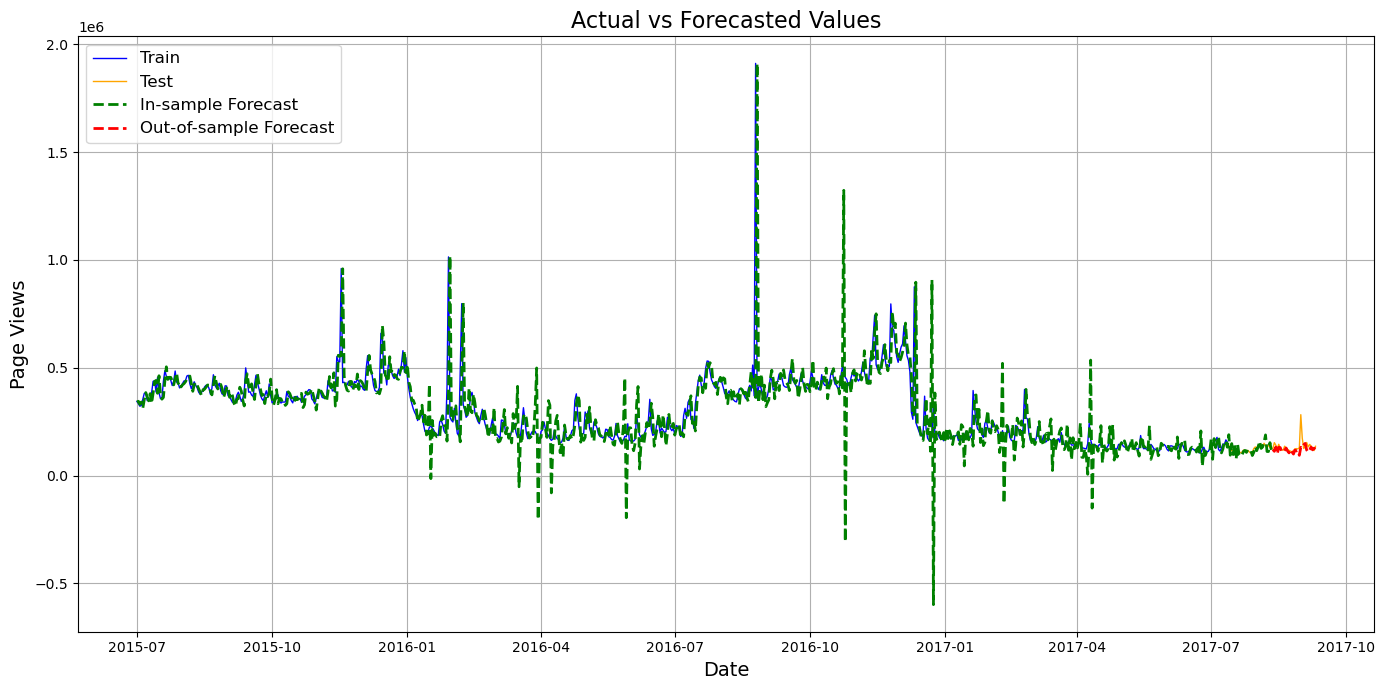

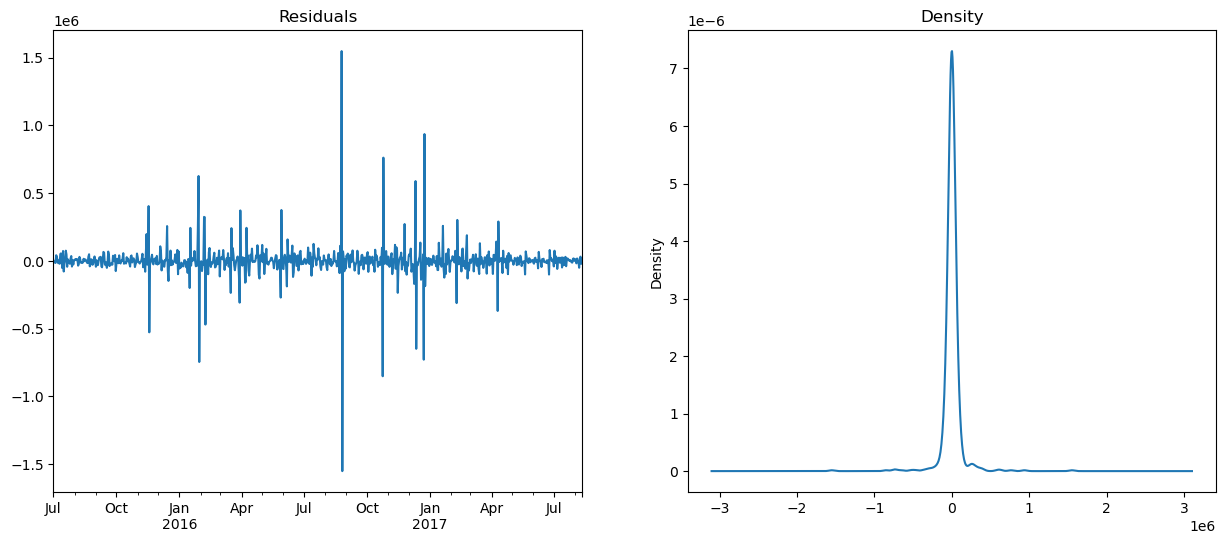

In [107]:
def smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

def check_residuals(model):
    residuals = model.resid
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    residuals.plot(ax=ax[0], title="Residuals")
    residuals.plot(kind='kde', ax=ax[1], title="Density")
    plt.show()
    
def plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(train_series, label='Train', color='blue', linewidth=1)
    ax.plot(test_series, label='Test', color='orange', linewidth=1)
    
    # In-sample forecast
    in_sample_forecast = model.fittedvalues
    ax.plot(in_sample_forecast, label='In-sample Forecast', color='green', linestyle='--', linewidth=2)
    
    # Out-of-sample forecast
    forecast = model.get_forecast(steps=len(test_series), exog=test_exog)
    forecast_index = pd.date_range(start=test_series.index[0], periods=len(test_series), freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    ax.plot(forecast_series, label='Out-of-sample Forecast', color='red', linestyle='--', linewidth=2)

    sMAPE_value = smape(test_series, forecast_series)
    print(f'sMAPE: {sMAPE_value:.2f}%')
    
    # Adding titles and labels
    ax.set_title('Actual vs Forecasted Values', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Page Views', fontsize=14)
    
    # Adding legend
    ax.legend(loc='upper left', fontsize=12)
    
    # Adding grid for better readability
    ax.grid(True)
    
    # Improving the appearance
    plt.tight_layout()
    
    plt.show()

def plot_model_forecast(data, date_columns, page_name, test_size):
    try:
        with open(os.path.join(SARIMAX_CATEGORY_CLUSTER_DIR, f'best_agg_model_{page_name}.pkl'), 'rb') as f:
            best_model_info = pickle.load(f)
    except FileNotFoundError:
        print('FileNotFoundError')
        return
    
    model = best_model_info['model']
    
    time_series, exog = get_time_series_and_exog(data, page_name)
    
    if time_series is not None:
        train_series, test_series, train_exog, test_exog = train_test_split(time_series, exog, test_size)
        plot_forecast_vs_actual(train_series, test_series, train_exog, test_exog, model)
        check_residuals(model)


page_name = 19

plot_model_forecast(aggregated_df, date_columns, page_name, test_size=60)

In [111]:
def forecast(model, ts, exog):
    forecast = model.get_forecast(steps=len(ts), exog=exog)
    forecast_index = pd.date_range(start=ts.index[0], periods=len(ts), freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    return forecast_series

smape_list = []
for page_name in range(20):
    try:
        with open(os.path.join(SARIMAX_CATEGORY_CLUSTER_DIR, f'best_agg_model_{page_name}.pkl'), 'rb') as f:
            best_model_info = pickle.load(f)
    except FileNotFoundError:
        print('FileNotFoundError')
    
    model = best_model_info['model']
    
    time_series, exog = get_time_series_and_exog(aggregated_df, page_name)
    train_series, test_series, train_exog, test_exog = train_test_split(time_series, exog, test_size)
    forecast_series = forecast(model, test_series, test_exog)
    sMAPE_value = smape(test_series, forecast_series)
    smape_list.append(sMAPE_value)

In [113]:
np.mean(smape_list)

22.637964777042594

In [115]:
aggregated_df.to_csv(os.path.join(SARIMAX_CATEGORY_CLUSTER_DIR, 'data.csv'), index_label='date')

In [117]:

with open(os.path.join(SARIMAX_CATEGORY_CLUSTER_DIR,'topic_exog_features.pkl'), 'wb') as f:
    pickle.dump(topic_exog_features, f)

In [119]:
topic_exog_features[13]

,total_edits,total_bytes_added,unique_editors,mobile edit,mobile web edit,visualeditor,mw-reverted,mobile app edit,contenttranslation,visualeditor-switched,end_of_day_size
date,,,,,,,,,,,
2015-07-01,10.0,165.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1745029.0
2015-07-02,14.0,90.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1745120.0
2015-07-03,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1745145.0
2015-07-04,6.0,21.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1745681.0
2015-07-05,6.0,-95.0,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1745584.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-09-06,5.0,-58.0,5.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1888660.0
2017-09-07,6.0,682.0,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1888648.0
2017-09-08,9.0,-297.0,6.0,6.0,4.0,0.0,0.0,2.0,0.0,0.0,1888419.0
